# TP2 - COMPUTER VISION I
##### Alumno: Diego Araujo

-------------------

**Objetivo:**

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template `Material_TPs/TP3/template`
1.  Obtener una detección del logo en cada imagen sin falsos positivos
2. Plantear y validar un algoritmo para múltiples detecciones en la imagen `coca_multi.png` con el mismo template del ítem 1.
3. Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

## Importación de paquetes

In [1]:
# ---------------- Paquetes a utilizar ----------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import cv2 as cv


## Funciones auxiliares


In [ ]:
# ---------------- Nivel de confianza ----------------

def nivel_confianza(matrix):
    
    max_val = np.max(matrix)
    median_val = np.median(matrix)
    
    if max_val == 0:
        return 0  # Para evitar divisiones por cero
    
    conf = np.min([(max_val - median_val) / max_val, 1])
    
    return conf

## Detección del logo en cada imagen (sin falsos positivos)

En este sección se cargarán las imágenes para posteriormente detectar el logo (template) en cada una, evitando obtener falsos positivos. 

In [ ]:
# ---------------- Mapeo de paths ----------------

# Se mapean los paths de las imánetes y dejarlos en un array para después utilizar en función iterativa

template = 'template\\pattern.png'
folder_img = 'images'

img_paths= []

for file_name in os.listdir(folder_img):

    full_path = os.path.join(folder_img, file_name)
    img_paths.append(full_path)

Se escribe la función `detect_template` para detectar coincidencias del template dentro de la imagen utilizando la técnica de *simple matching* (`matchTemplate`) para distintos tamaños del template (dado que puede diferir con respecto al tamaño de la imagen).

El algoritmo de forma concreta, realiza lo siguiente:

1) Carga la imagen principal y el template
2) Hace un preprocesamiento del template|imagen (e.g. *escala de grises*, *desenfoque gaussiano* para reducir el ruido
3) Se detectan bordes a través de *Canny*, tanto en imagen principal como template
4) Se define un rango de escalas para probar el redimensionamiento del template, e itera sobre ellas haciendo redimensión del template
5) Se utiliza `cv.matchTemplate` para encontrar coincidencias entre el template redimensionado y la imagen.
6) Guarda la mejor coincidencia basada en el valor de correlación más alto.
7) Muestra el resultado, resaltando la región coincidente (con un box verde) y el nivel de confianza obtenido para la mejor coincidencia.

Para el nivel de confianza se crea la función específica `nivel_confianza` basada en una normalización a través de la mediana y truncada entre $[0,1]$, siendo 1 el valor más alto de confianza. La fórmula del indicador se puede resumir de la siguiente manera:

$$confianza = min\left(\frac{\text{valor máximo} - \text{mediana de la matriz}}{\text{valor máximo}}, 1\right)$$

donde:

- *valor máximo* es el mayor valor en la matriz.
- *mediana de la matriz* es el valor que se encuentra en la mitad de los datos ordenados.
- La función `min(·, 1)` se utiliza para truncar el valor máximo del indicador a 1, asegurando que siempre esté en el rango [0, 1].



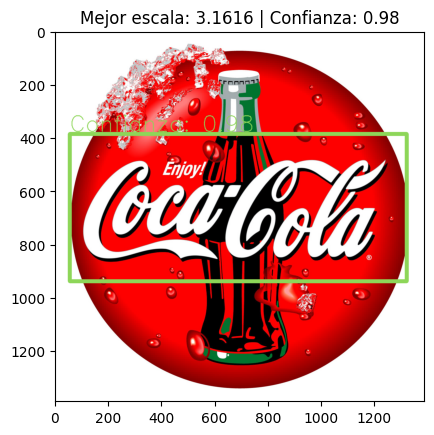

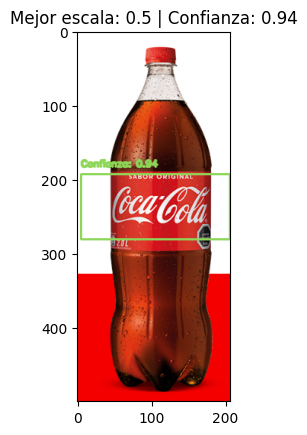

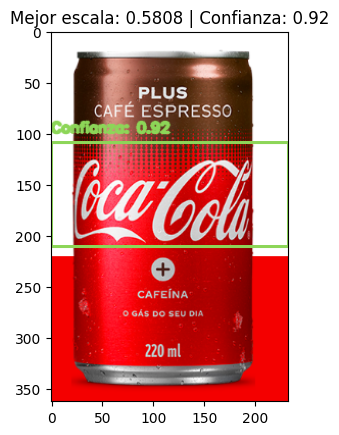

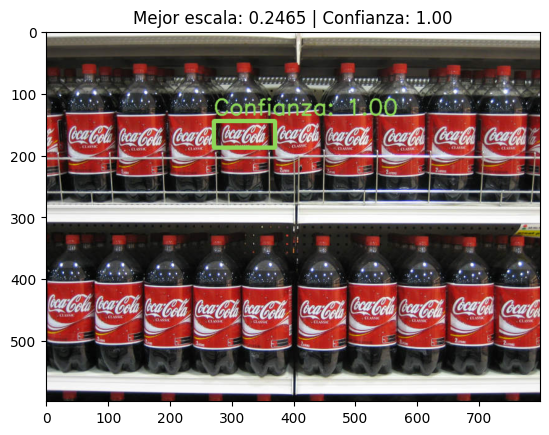

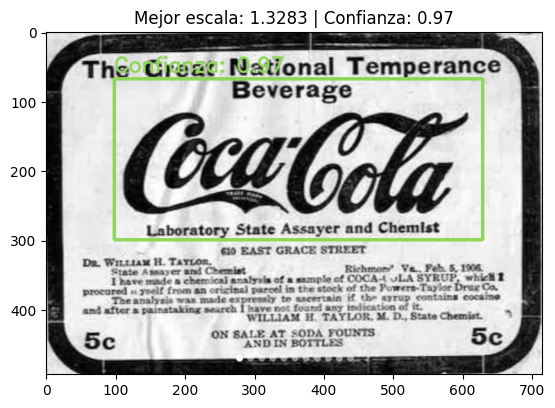

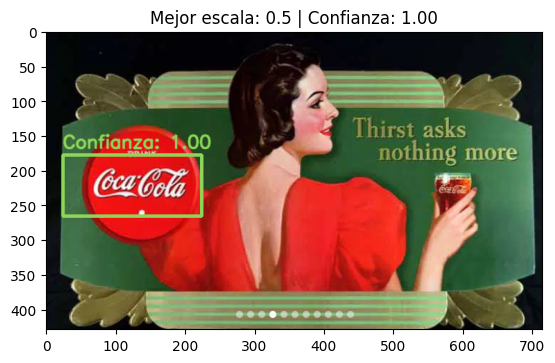

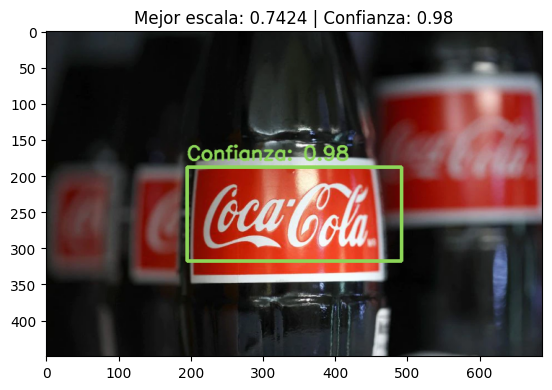

In [31]:
def detect_template(image_path, template_path):

    # Carga de imagen / template
    image = cv.imread(image_path)
    template = cv.imread(template_path)

    # Paso a escala de grises
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    gray_tmp = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

    # Desenfoque gaussiano a la imagen / template (para sacar ruido)
    blurred_image = cv.GaussianBlur(gray_image, (5, 5), 0)
    blurred_tmp = cv.GaussianBlur(gray_tmp, (5, 5), 0)

    # Aplicar detección de bordes con Canny a través de percentiles
    # median_value = np.median(blurred_image)
    lower = int(np.percentile(blurred_image, 45))
    upper = int(np.percentile(blurred_image, 55))
    edged_image = cv.Canny(blurred_image, lower, upper, L2gradient=True)

    # median_value_tmp = np.median(blurred_tmp)
    lower_tmp = int(np.percentile(blurred_tmp, 45))
    upper_tmp = int(np.percentile(blurred_tmp, 55))
    edged_tmp = cv.Canny(blurred_tmp, lower_tmp, upper_tmp, L2gradient=True)

    # Definir escalas para redimensionar el template
    height_ratio = edged_tmp.shape[0] / edged_image.shape[0]
    width_ratio = edged_tmp.shape[1] / edged_image.shape[1]
    
    if height_ratio < 0.3 and width_ratio > 0.4:
        min_scale, max_scale = 0.2, 2.5
    elif height_ratio < 0.2 and width_ratio < 0.3:
        min_scale, max_scale = 3.0, 4.0 
    else:
        min_scale, max_scale = 0.5, 2.5

    # Rango de escalas para redimensionar el template (para probar varios tamaños)
    scales = np.linspace(min_scale, max_scale, 100)

    # Inicializar variables para guardar el mejor resultado
    best_match = None
    best_scale = None
    best_max_val = -np.inf
    best_top_left = None

    # Iteración para encontrar el mejor ajuste (tamaño) del template en la imagen
    for scale in scales:

        # Redimensionar el template
        resized_template = cv.resize(template, None, fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
        
        # Aplicar detección de bordes al template redimensionado
        edged_template = cv.Canny(resized_template, lower, upper, L2gradient=True)

        # Dimensiones del template redimensionado
        w, h = edged_template.shape[::-1]

        # Control de que el template redimensionado cabe en la imagen
        if w <= edged_image.shape[1] and h <= edged_image.shape[0]:
            
            # Se aplica matching template
            res = cv.matchTemplate(edged_image, edged_template, cv.TM_CCOEFF_NORMED)
            #print(res)

            # Valor máximo + ubicación
            _, max_val, _, max_loc = cv.minMaxLoc(res)

            # Actualizar el mejor resultado si es necesario
            if max_val > best_max_val:
                best_max_val = max_val
                best_scale = scale
                best_match = resized_template
                best_top_left = max_loc
                conf_level = nivel_confianza(res)
                                
            # plt.imshow(res)
            # plt.show()

    # Rectángulo del mejor ajuste en la imagen original
    if best_match is not None:
        bottom_right = (best_top_left[0] + best_match.shape[1], best_top_left[1] + best_match.shape[0])

        # Grosor del rectángulo
        stroke_thickness = max(1, int(min(image.shape[:2]) / 100))

        # Rectángulo y etiqueta con la confianza
        cv.rectangle(image, best_top_left, bottom_right, (88, 214, 141), stroke_thickness)
        text = f'Confianza: {conf_level:.2f}'
        font = cv.FONT_HERSHEY_SIMPLEX
        font_scale = min(image.shape[0], image.shape[1]) / 500
        font_thickness = 2
        text_size = cv.getTextSize(text, font, font_scale, font_thickness)[0]
        text_x = best_top_left[0]
        text_y = best_top_left[1] - 10 if best_top_left[1] - 10 > 10 else best_top_left[1] + text_size[1] + 10
        cv.putText(image, text, (text_x, text_y), font, font_scale, (88, 214, 141), font_thickness, cv.LINE_AA)

        # Se imprime resultado
        plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
        plt.title(f'Mejor escala: {np.round(best_scale,4)} | Confianza: {conf_level:.2f}')
        plt.show()

# Ejecución
for img_path in img_paths:
    detect_template(img_path, 'template//pattern.png') 

Según los outputs se pueden observar varios puntos:
- El algoritmo parece funcionar de manera precisa en la mayoría de los casos ya que en cada imagen, el logo (*template*) está correctamente indicado y el nivel de confianza es bastante alto (mayor a $90\%$) en casi todas las detecciones.
- El algoritmo ha demostrado ser eficaz al detectar el logo de Coca-Cola en diferentes tamaños y escalas.
- Las imágenes incluyen diferentes tipos de entornos (fotos, etiquetas antiguas, etc.), variando también la calidad o resolución, por lo que la detección en varios de ellos indica una buena generalización del algoritmo en diferentes contextos.
- Esto muestra que el algoritmo ha podido adaptarse adecuadamente a la relación de tamaños entre el template y el logo en las imágenes



## Algoritmo para múltiples detecciones

En este caso se crea un algoritmo para múltiples detecciones en la imagen `coca_multi.png` con el mismo template que se venía utilizando.

Se crea una función de *supresión no máxima (NMS)* para filtrar y eliminar detecciones redundantes. El algoritmo de *NMS* funciona de la siguiente manera:
1) Selecciona la detección con la mayor puntuación de confianza.
2) Elimina todas las detecciones que se solapan con la detección seleccionada por encima de un cierto umbral.
3) El umbral de solapamiento se mide utilizando el IoU (Intersection over Union), que es la relación entre la intersección y la unión de las áreas de los boxes.
4) Este proceso se repite para las detecciones restantes. Al final, solo se conserva una única detección por objeto.

Esto ayuda a mejorar la precisión y reduce las falsas detecciones.

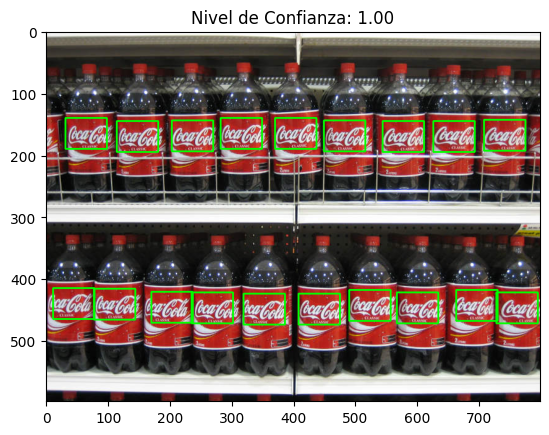

In [32]:
def non_max_suppression(boxes, scores, iou_threshold):

    # Si no hay cajas, devolver listas vacías
    if len(boxes) == 0:
        return [], []

    # Se convierten las coordenadas de las cajas a floats (para que no genere ningún error)
    boxes = boxes.astype(float)

    # Lista vacía de índices de las cajas
    keep = []

    # Se ordenan las puntuaciones en orden descendente y se obtienen los índices
    idxs = np.argsort(-scores)

    while len(idxs) > 0:
        
        # Se toma el índice de la caja con la puntuación más alta
        current_idx = idxs[0]
        keep.append(current_idx)

        # Se obtiene la caja actual
        current_box = boxes[current_idx]

        # Se calculan las coordenadas de intersección entre la caja actual y todas las restantes
        other_boxes = boxes[idxs[1:]]
        x1 = np.maximum(current_box[0], other_boxes[:, 0])
        y1 = np.maximum(current_box[1], other_boxes[:, 1])
        x2 = np.minimum(current_box[0] + current_box[2], other_boxes[:, 0] + other_boxes[:, 2])
        y2 = np.minimum(current_box[1] + current_box[3], other_boxes[:, 1] + other_boxes[:, 3])

        # Se calcula el área de intersección
        inter_area = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)

        # Se calcula el área de las otras cajas y la caja actual
        current_area = current_box[2] * current_box[3]
        other_areas = other_boxes[:, 2] * other_boxes[:, 3]

        # Se calcula el IoU (Intersection over Union)
        iou = inter_area / (current_area + other_areas - inter_area)

        # Nos quedamos solo con las cajas que el IoU esté por debajo del umbral
        idxs = idxs[np.where(iou < iou_threshold)[0] + 1]

    # Devuelve los índices de las cajas a conservar y sus correspondientes puntuaciones
    return keep, scores[keep]


# Se carga y preprocesa la imagen
img_rgb = cv.imread('images/coca_multi.png')
img_gray_blurred = cv.GaussianBlur(cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY), (5, 5), 0)

# Se cargar, redimensiona y aplica detección de bordes al template
template = cv.resize(cv.imread('template/pattern.png', 0), 
                     (int(img_gray_blurred.shape[1] * 0.085), int(img_gray_blurred.shape[0] * 0.085)))
template_edges = cv.Canny(template, 100, 200, L2gradient=True)

# Se aplica detección de bordes a la imagen y realizar la búsqueda del template
res = cv.matchTemplate(cv.Canny(img_gray_blurred, 10, 250, L2gradient=True), 
                       template_edges, cv.TM_CCOEFF_NORMED)

# Ubicaciones coincidentes, cajas y puntuaciones
loc = np.where(res >= 0.16)
boxes = np.array([[pt[0], pt[1], template.shape[1], template.shape[0]] for pt in zip(*loc[::-1])])
scores = np.array([res[pt[1], pt[0]] for pt in zip(*loc[::-1])])

# Se aplica supresión no máxima y se calcula los niveles de confianza
keep, keep_scores = non_max_suppression(boxes, scores, 0.4)
confidence_levels = nivel_confianza(res)
global_confidence_level = np.median(confidence_levels)

# Se dibujan las cajas y se genera el output
for i in keep:
    cv.rectangle(img_rgb, (boxes[i, 0], boxes[i, 1]), 
                 (boxes[i, 0] + boxes[i, 2], boxes[i, 1] + boxes[i, 3]), (0, 255, 0), 2)

plt.imshow(cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB))
plt.title(f'Nivel de Confianza: {global_confidence_level:.2f}')
plt.show()

Algunas observaciones:
- El algoritmo ha sido capaz de identificar correctamente varias instancias del patrón en la imagen
- El nivel de confianza global es 1.00, lo que sugiere que las coincidencias detectadas son muy precisas y consistentes, dado que la confianza es máxima en todas las detecciones
- La imagen muestra que el algoritmo funciona bien en entornos con objetos repetitivos y uniformes